In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for nltk
import re
import nltk
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS

# Packages for k-means
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import MDS
import os

# Package for saving df as txt files
import pickle

plt.rcParams["figure.figsize"] = [10, 8]

In [2]:
# Read data frame with unique articles and tweets.
all_nodup = pd.read_pickle("data/all_nodup.txt")

In [3]:
# Jonathan's functions for tokenizing with regex.
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if (re.search("[0-9:\\.`'“’(),”\-@—&;$#!\*\+\?_/]|https|\\bamp\\b|rt", token) is None) and re.search("[a-zA-Z]", token):
            filtered_tokens.append(token)
    return filtered_tokens

In [4]:
# Generate the tfidf matrix for the df with all the news sources.
text_list = all_nodup['text'].tolist()

vec = TfidfVectorizer(tokenizer = tokenize_only, 
                      stop_words = "english", 
                      sublinear_tf = True)
tfidf = vec.fit_transform(text_list)

In [6]:
# See the dimensions of the tfidf.
tfidf

<2555x16684 sparse matrix of type '<class 'numpy.float64'>'
	with 141189 stored elements in Compressed Sparse Row format>

In [7]:
# See the terms in the tfidf matrix.
terms = vec.get_feature_names()
terms[:10]

['^eas',
 'aanestad',
 'aaron',
 'aau',
 'ab',
 'aback',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment']

In [8]:
# K-means clustering with 3 clusters
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf)

clusters = km.labels_.tolist()

In [9]:
# Add the article's assigned cluster to the dataframe called "frame"
nodupe_k = all_nodup
nodupe_k["cluster"] = clusters
frame = nodupe_k
frame.head()

,text,title,source,cluster
0,"California wildfires are raging this summer, b...",California Fires Map: Get the Latest Updates f...,Google News,0
1,"California wildfires are burning again, with t...","California Fires: Wildfires Map for Camp, Wool...",Google News,0
2,"Corrected, Dec. 12., 3:05p.m. ET\n\nFollowing ...",35 Paradise Families Sue PG&E Over California'...,Google News,0
3,It’s one thing to read about the massive devas...,Heartbreaking 360-Degree Film Shows Aftermath ...,Google News,0
4,PG&E is restructuring its board following the ...,PG&E Board of Directors Is Restructuring After...,Google News,0


In [10]:
# See the number of articles/tweets per cluster
frame['cluster'].value_counts()

0    2013
1     399
2     143
Name: cluster, dtype: int64

In [11]:
# This code was adapted from http://brandonrose.org/clustering. For each cluster, it shows the 10 words that 
# are closest to each cluster centroid.

from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 10 with n words per cluster
        print(' %s' % terms[ind], end=',')
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: camp, california, s, paradise, wildfire, people, said, pg, e, deadliest,
Cluster 0 titles: California Fires Map: Get the Latest Updates from Google, No RVs or temporary housing on property until clean-up is complete, Paradise council decides, Tweet 0,

Cluster 1 words: says, e, pg, equipment, probably, caused, camp, california, probable, deadly,
Cluster 1 titles: California Fires: Wildfires Map for Camp, Woolsey, Hill Fires, PUSD to ask for requests for proposals on tree removals, Tweet 1,

Cluster 2 words: dog, days, family, reunited, lost, wildfire, reunites, california, later, eating,
Cluster 2 titles: 35 Paradise Families Sue PG&E Over California's Camp Fire, Theatre on the Ridge reopens, Radioland show returns, Tweet 2,



In [12]:
# Calculate the cosine distance.
dist = 1 - cosine_similarity(tfidf)

In [13]:
# This code was adapted from http://brandonrose.org/clustering. It converts a distance matrix into 
# two dimensional data points. This allows us to plot and visually see the distances.

MDS()

# Convert two components as we're plotting points in a two-dimensional plane
# Set dissimilarity to "precomputed" because we provide a distance matrix
# Set `random_state` so the plot is reproducible

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist) 
xs, ys = pos[:, 0], pos[:, 1]

In [17]:
# Set up cluster names and cluster colors
cluster_labels = {0: 'Camp, california, s, paradise, wildfire, people',
                  1: 'Says, pg, e, equipment, probably, caused', 
                  2: 'Dog, days, family, reunited, lost, wildfire'}

cluster_colors = {"Google News": 'cornflowerblue', "Twitter": 'olivedrab', "Local": 'gold'}

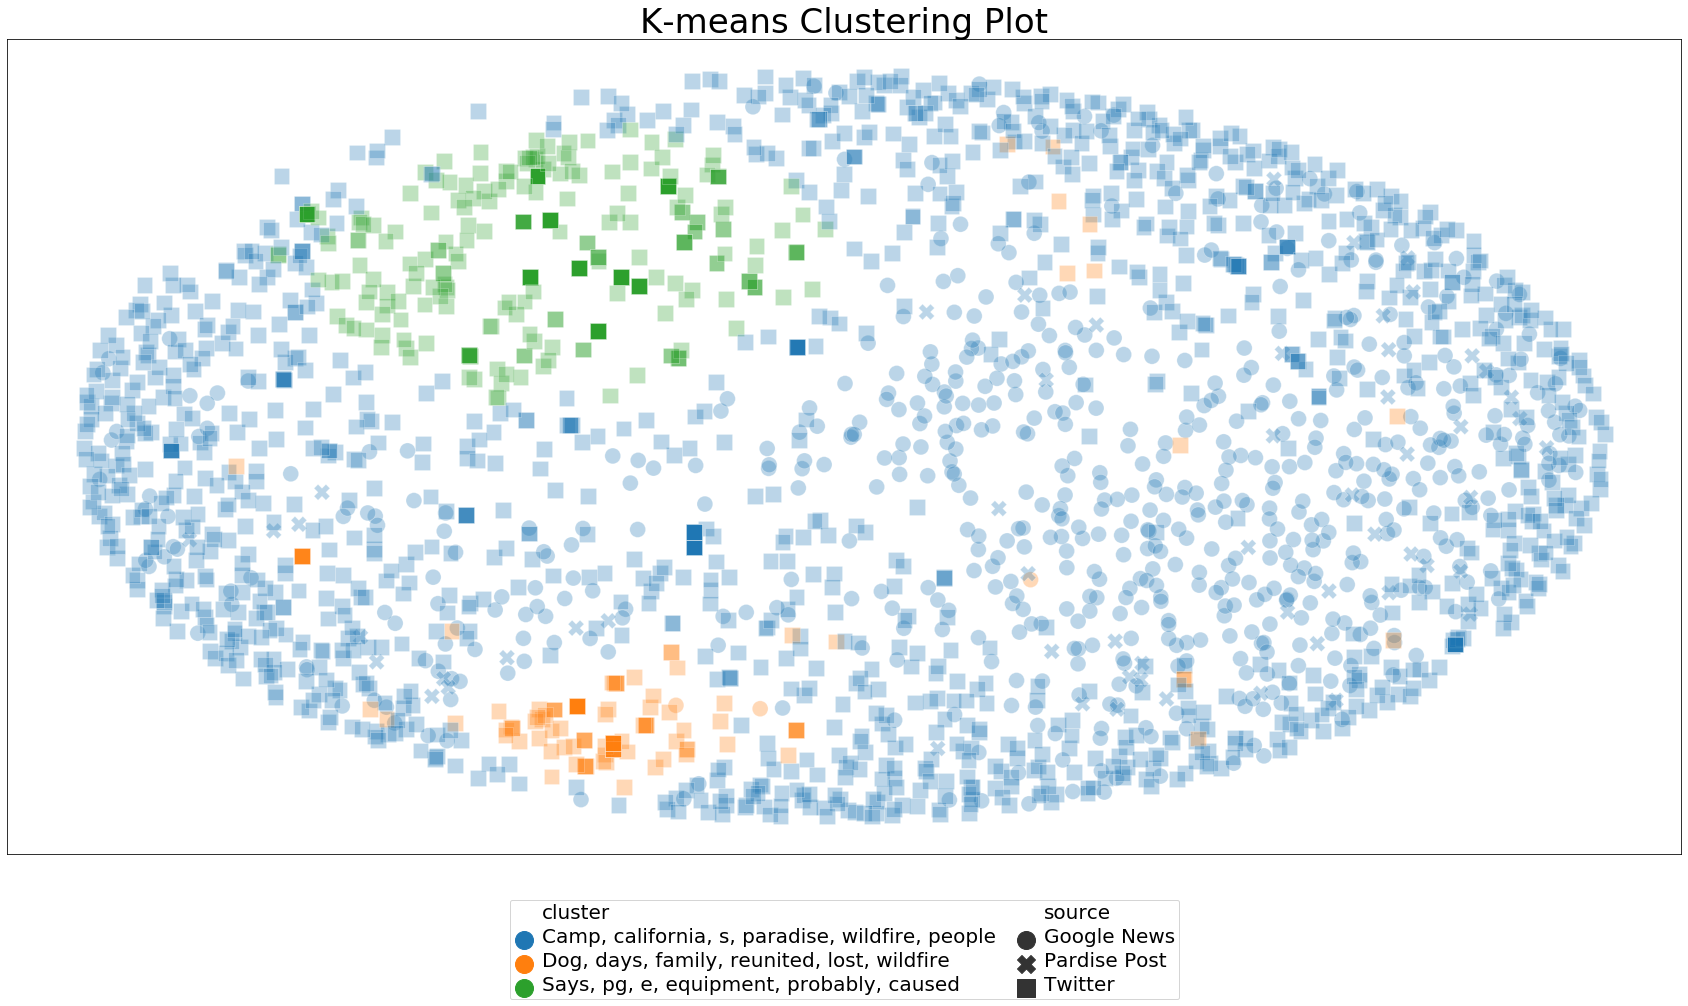

In [18]:
# Make the k-means clustering plot

titles = frame["title"]
source = frame["source"]

%matplotlib inline 
plt.figure(figsize=(30,15))

# Data frame that has the result of the MDS, clusters, titles, and source.
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles, source=source)) 
df['source'] = df['source'].str.replace('Local', "Pardise Post")


# Make a new column in the df that has the cluster labels.
df['cluster'] = df['label'].replace(cluster_labels)


ax = sns.scatterplot('x', 'y', data=df, hue='cluster', style = 'source', s = 250, alpha = 0.3)

# Set the title.
ax.set_title('K-means Clustering Plot', fontsize=34)

# Change the legend.
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, markerscale = 3)
plt.setp(ax.get_legend().get_texts(), fontsize='20') 

# Remove axis title and labels.
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)